# Imports

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import pandas as pd
from datetime import datetime 
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
import pickle
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from arch import arch_model

In [2]:
warnings.filterwarnings('ignore')

# Loading Data

In [3]:
ticker = yf.Ticker('meta')
df = ticker.history(interval='1d', start='2010-01-01', end='2023-01-01')

# Creating dummy date index to prevent frequency warnings/errors (missing value imputation not necessary because there should
# be no data on days the market is not open)
dummy_dates = pd.date_range(end=datetime.today(), periods=len(df))
df['Dummy Date'] = dummy_dates.date
df.index = df.index.tz_convert(None)
df = df.reset_index()
df = df.set_index('Dummy Date')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Dummy Date,,,,,,,,
2015-12-26,2012-05-18 04:00:00,42.049999,45.000000,38.000000,38.230000,573576400,0.0,0.0
2015-12-27,2012-05-21 04:00:00,36.529999,36.660000,33.000000,34.029999,168192700,0.0,0.0
2015-12-28,2012-05-22 04:00:00,32.610001,33.590000,30.940001,31.000000,101786600,0.0,0.0
2015-12-29,2012-05-23 04:00:00,31.370001,32.500000,31.360001,32.000000,73600000,0.0,0.0
2015-12-30,2012-05-24 04:00:00,32.950001,33.209999,31.770000,33.029999,50237200,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2673 entries, 2015-12-26 to 2023-04-20
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2673 non-null   datetime64[ns]
 1   Open          2673 non-null   float64       
 2   High          2673 non-null   float64       
 3   Low           2673 non-null   float64       
 4   Close         2673 non-null   float64       
 5   Volume        2673 non-null   int64         
 6   Dividends     2673 non-null   float64       
 7   Stock Splits  2673 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 187.9+ KB


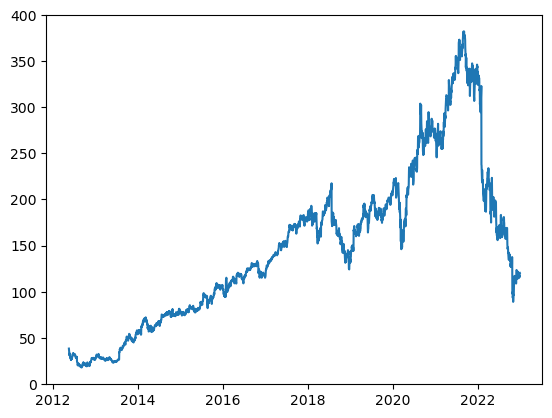

In [5]:
plt.plot(df['Date'], df['Close'])
plt.show()

# Stationarity

In [6]:
result = adfuller(df['Close'])
print('ADF Test Statistic: {}'.format(result[0]))
print('ADF P-value: {}'.format(result[1]))

ADF Test Statistic: -1.5754932255011262
ADF P-value: 0.49589128016045153


Based on the p-value of the ADF test, we fail to reject the null hypothesis and therefore, the data is not stationary.

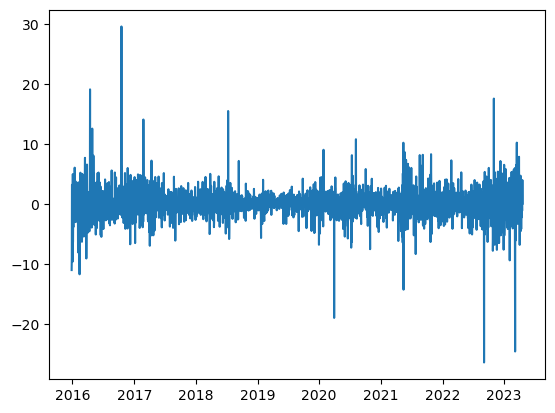

In [7]:
returns = 100 * df['Close'].pct_change().dropna()
plt.plot(returns)
plt.show()

In [8]:
result = adfuller(returns)
print('ADF Test Statistic: {}'.format(result[0]))
print('ADF P-value: {}'.format(result[1]))

ADF Test Statistic: -16.658625230791504
ADF P-value: 1.5812233593914028e-29


By taking the first difference of the closing price, we see that the resulting p-value of the ADF test is now less than 0.05, so we can reject the null hypothesis and conclude that the returns are stationary. We also can conlude that the parameter, d, corresponding to the integrated component of our SARIMA model should be set to 1.

# Train/Test Split

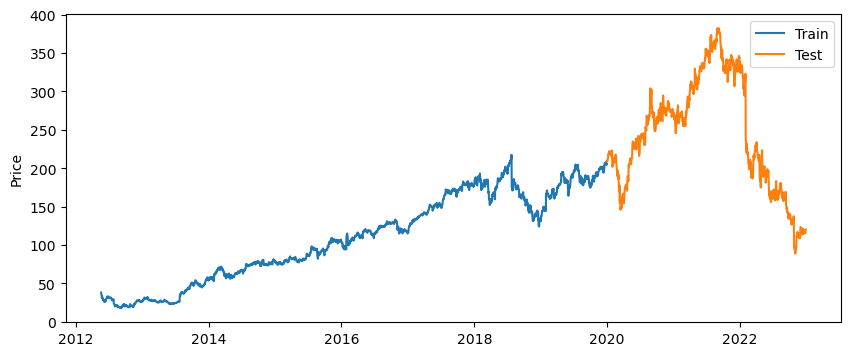

In [9]:
max_date = df.loc[df['Date'] < datetime(2020, 1, 1)].index.max()
max_train_idx = df.index.get_loc(max_date)

plt.figure(figsize=(10,4))
plt.plot(df.iloc[:max_train_idx + 1]['Date'], df.iloc[:max_train_idx + 1]['Close'], label='Train')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close'], label='Test')
plt.ylabel('Price')
plt.legend()
plt.show()

# PACF and ACF Plots

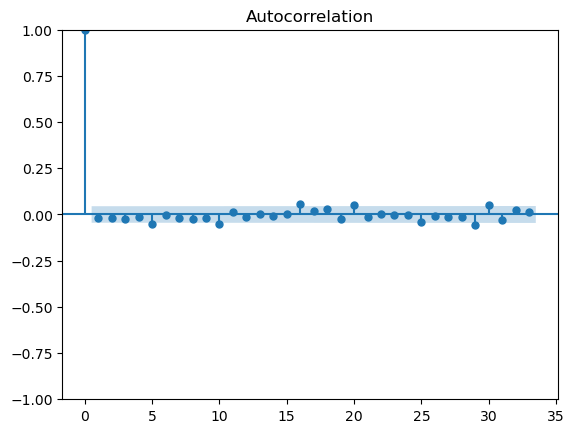

In [10]:
plot_acf(df.iloc[:max_train_idx + 1]['Close'].diff().dropna())
plt.show()

Based on the ACF plot, possible values of the moving average (MA) component of the model could be {5, 10, 16}

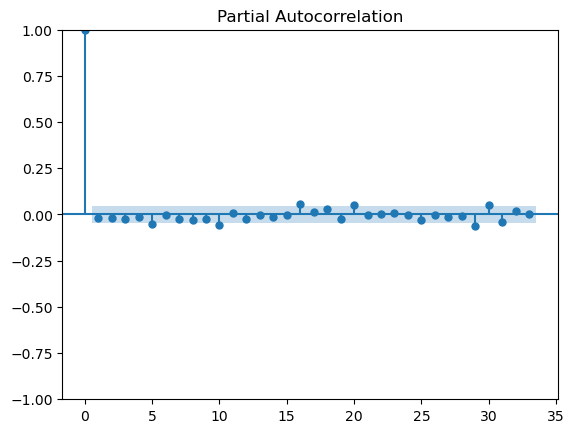

In [11]:
plot_pacf(df.iloc[:max_train_idx + 1]['Close'].diff().dropna(), method='ywm')
plt.show()

Based on the PACF plot, possible values of the autoregressive (AR) component of the model could be {5, 10, 16}

# ARIMA Parameter Tuning

In [16]:
# ARIMA (5, 1, 5)
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(5, 1, 5), missing='raise', freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1917
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -4305.809
Date:                Thu, 20 Apr 2023   AIC                           8625.617
Time:                        21:12:04   BIC                           8664.523
Sample:                    12-26-2015   HQIC                          8639.934
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7329      0.144      5.098      0.000       0.451       1.015
ar.L2         -0.0048      0.020     -0.239      0.811      -0.044       0.034
ar.L3         -0.0120      0.025     -0.478      0.633      -0.061       0.037
ar.L4          0.0033      0.024      0.139      0.890      -0.043       0.050
ar.L5         -0.0300      0.021     -1.402      0.161      -0.072       0.012
ma.L1         -0.7533      0.142     -5.322      0.000      -1.031      -0.476
sigma2         5.2419      0.042    124.332      0.000       5.159       5.325
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            282815.44
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               7.99   Skew:                            -2.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see that only the AR 1 and MA 1 components are significant so we can reduce the model to an ARIMA (1, 1, 1) model.

In [17]:
# ARIMA (1, 1, 1)
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(1, 1, 1), missing='raise', freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1917
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4307.291
Date:                Thu, 20 Apr 2023   AIC                           8620.581
Time:                        21:18:03   BIC                           8637.255
Sample:                    12-26-2015   HQIC                          8626.717
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8377      0.095      8.820      0.000       0.652       1.024
ma.L1         -0.8699      0.087    -10.055      0.000      -1.040      -0.700
sigma2         5.2500      0.039    133.024      0.000       5.173       5.327
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):            276917.90
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               8.04   Skew:                            -2.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now all the coefficients are significant, so we will choose to use an ARIMA(1, 1, 1) model for training and testing.

# ARIMA (1, 1, 1) Model

In [18]:
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(1, 1, 1), missing='raise', freq='D')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1917
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4307.291
Date:                Thu, 20 Apr 2023   AIC                           8620.581
Time:                        21:19:53   BIC                           8637.255
Sample:                    12-26-2015   HQIC                          8626.717
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8377      0.095      8.820      0.000       0.652       1.024
ma.L1         -0.8699      0.087    -10.055      0.000      -1.040      -0.700
sigma2         5.2500      0.039    133.024      0.000       5.173       5.327
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):            276917.90
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               8.04   Skew:                            -2.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

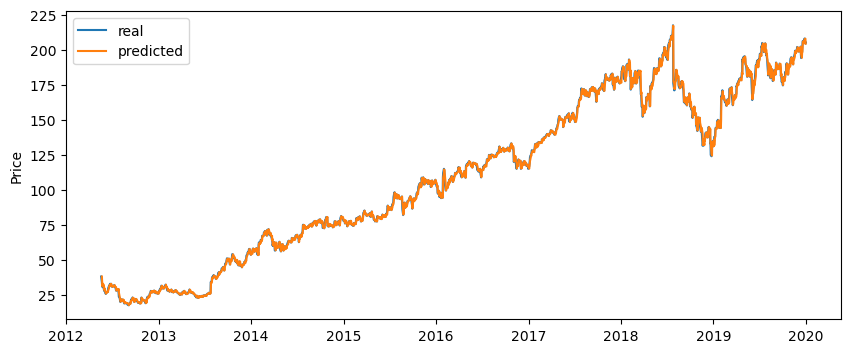

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(df.iloc[:max_train_idx + 1]['Date'], df.iloc[:max_train_idx + 1]['Close'], label='real')
plt.plot(df.iloc[1:max_train_idx + 1]['Date'], results.fittedvalues[1:], label='predicted')
plt.legend()
plt.ylabel('Price')
plt.show()

In [20]:
# Train Results
mse = mean_squared_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
mae = mean_absolute_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
mape = mean_absolute_percentage_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
rmse = np.sqrt(mse)

print('MSE: {}\nRMSE: {}\nMAE: {}\nMAPE: {}'.format(mse, rmse, mae, mape))

MSE: 5.250135622401113
RMSE: 2.29131744252103
MAE: 1.396540038875882
MAPE: 0.014711384075047525


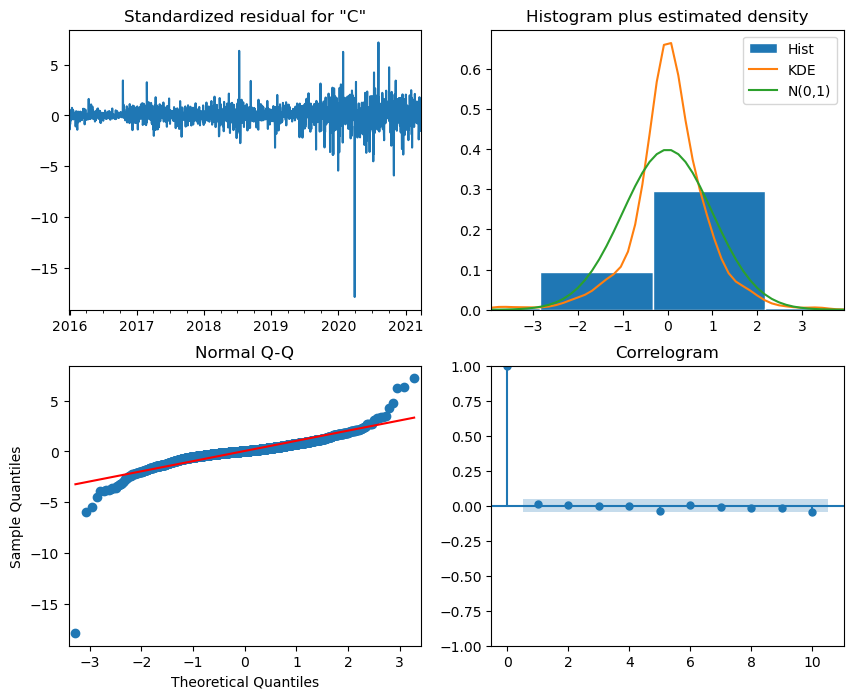

In [21]:
fig = plt.figure(figsize=(10, 8))
results.plot_diagnostics(fig=fig)
plt.show()

Based on the diagnostic plots, the residuals do appear to be normally distributed with mean 0 and a constant variance. To confirm these conclusions, we run an Ljung-Box test to check for autocorrelation and a Breusch Pagan test to check for heteroskedasticity. 

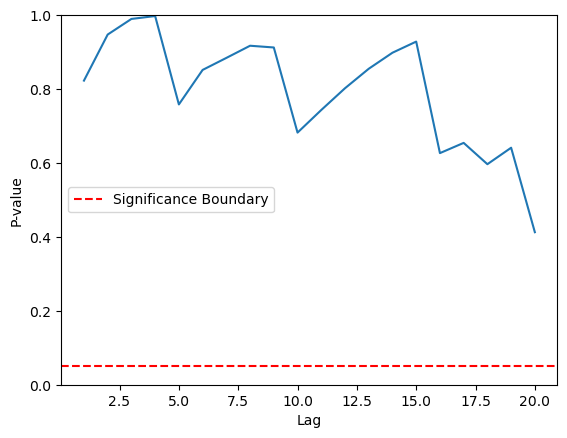

In [24]:
# Use Ljung-Box to statistically test for autocorrelation of residuals in the first 20 lags
resid_test = acorr_ljungbox(results.resid, lags=20, return_df=True)
plt.plot(resid_test['lb_pvalue'])
plt.axhline(0.05, linestyle='--', color='red', label='Significance Boundary')
plt.legend()
plt.ylim([0, 1])
plt.ylabel('P-value')
plt.xlabel('Lag')
plt.show()

The null hypothesis of the Ljung-Box test is that the residuals are independently distributed. Based on the figure above, we fail to reject the null hypothesis for the first 20 lags and conclude that the residuals are independently distributed (i.e. they do not exhibit serial correlation).

In [25]:
# Breusch-Pagan test for heteroskedasticity
n = len(df.iloc[1:max_train_idx + 1]) 
exog = np.zeros((n, 2))
exog[:, 0], exog[:, 1] = df.iloc[1:max_train_idx + 1]['Date'], df.iloc[1:max_train_idx + 1]['Close']

bp_test = het_breuschpagan(results.resid[1:], exog)
print('BP Test Statistic: {}'.format(bp_test[0]))
print('BP P-value: {}'.format(bp_test[1]))

BP Test Statistic: 2.289974487191067
BP P-value: 0.1302120634163856


Based on the results of the Breusch Pagan test, we fail to reject the null hypothesis and conclude that the residuals are homoskedastic.

# Rolling Forecast Origin

In [26]:
predictions = results.fittedvalues.to_list()

tqdm._instances.clear()
for i in tqdm(range(len(df) - max_train_idx - 1)):
    
    # Train the model
    model = SARIMAX(df.iloc[i:max_train_idx + 1 + i]['Close'], order=(1, 1, 1), 
                    initialization='approximate_diffuse').fit(maxiter=200)
    
    # Forecast
    forecast = model.forecast()[0]
    predictions.append(forecast)

df['Close Predictions'] = predictions

100%|████████████████████████████████████████████████████████████████████████████████| 756/756 [02:14<00:00,  5.62it/s]


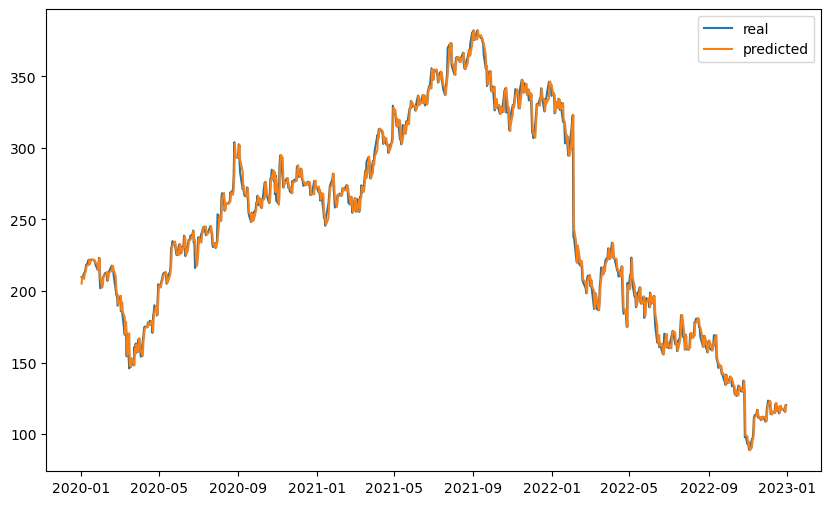

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close'], label='real')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close Predictions'], label='predicted')
plt.legend()
plt.show()

In [28]:
# Test Results
mse = mean_squared_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
mae = mean_absolute_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
mape = mean_absolute_percentage_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
rmse = np.sqrt(mse)

print('MSE: {}\nRMSE: {}\nMAE: {}\nMAPE: {}'.format(mse, rmse, mae, mape))

MSE: 47.73937042770762
RMSE: 6.909368308876552
MAE: 4.6889070988967365
MAPE: 0.020908944091183507


In [34]:
# Saving Data
df = df.set_index('Date')
df['Test Marker'] = [np.nan if x != max_train_idx + 1 else 'Start of Test Data' for x in range(len(df))]
df.to_csv('Processed Meta Data.csv')